In [1]:
# Import libraries

# Data manipulation and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Data preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Machine learning model
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance

# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix

In [2]:
# CLEANING DATA 

# Load the dataset from the GitHub repository
url = "https://github.com/kristenauriemma/595Project/raw/main/USvideos.csv"
df = pd.read_csv(url)
print(df.head())

# Convert 'trending_date' to datetime format (DD.MM.YY)
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%d.%m.%y', errors='coerce')

# Drop rows with invalid 'trending_date' but keep those with valid views
df = df.dropna(subset=['trending_date'])
# Drop rows with missing 'video_id'
df = df.dropna(subset=['video_id'])
# Drop duplicates
df = df.drop_duplicates()

# Ensure 'views' is numeric and remove rows where 'views' is NaN
df['views'] = pd.to_numeric(df['views'], errors='coerce')
df = df.dropna(subset=['views'])  # Drop rows where 'views' is NaN

# Handle missing values in other columns
numeric_columns = df.select_dtypes(include=['number']).columns

# Fill missing numeric columns with the mean
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Convert 'category_id' to category type (if you plan to use this in models)
df['category_id'] = df['category_id'].astype('category')

# Replace 0 with the median for likes, dislikes, and comment_count
median_likes = df['likes'].median() 
df['likes'] = df['likes'].replace(0, median_likes) 

median_dislikes = df['dislikes'].median() 
df['dislikes'] = df['dislikes'].replace(0, median_dislikes) 

median_comment = df['comment_count'].median() 
df['comment_count'] = df['comment_count'].replace(0, median_comment)

# Convert 'publish_time' to datetime and extract year, month, and day
df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')
df['publish_year'] = df['publish_time'].dt.year
df['publish_month'] = df['publish_time'].dt.month
df['publish_day'] = df['publish_time'].dt.day

# Extract year, month, and day from 'trending_date'
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m', errors='coerce')
df['trending_year'] = df['trending_date'].dt.year
df['trending_month'] = df['trending_date'].dt.month
df['trending_day'] = df['trending_date'].dt.day

# Reset index
df = df.reset_index(drop=True)

      video_id trending_date  \
0  2kyS6SvSYSE      17.14.11   
1  1ZAPwfrtAFY      17.14.11   
2  5qpjK5DgCt4      17.14.11   
3  puqaWrEC7tY      17.14.11   
4  d380meD0W0M      17.14.11   

                                               title          channel_title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE           CaseyNeistat   
1  The Trump Presidency: Last Week Tonight with J...        LastWeekTonight   
2  Racist Superman | Rudy Mancuso, King Bach & Le...           Rudy Mancuso   
3                   Nickelback Lyrics: Real or Fake?  Good Mythical Morning   
4                           I Dare You: GOING BALD!?               nigahiga   

   category_id              publish_time  \
0           22  2017-11-13T17:13:01.000Z   
1           24  2017-11-13T07:30:00.000Z   
2           23  2017-11-12T19:05:24.000Z   
3           24  2017-11-13T11:00:04.000Z   
4           24  2017-11-12T18:01:41.000Z   

                                                tags    views   lik

In [3]:
# PREPARING & PROCESSING DATA

# Create a 7-day moving average of views
df['views_7d_avg'] = df.groupby('video_id')['views'].rolling(window=7, min_periods=1).mean().reset_index(level=0, drop=True)
df['views_7d_avg'].fillna(0)

# Verify if the new feature has been added correctly
print(df[['video_id', 'trending_date', 'views', 'views_7d_avg']].head())

# Split the data into features (X) and target (y)
X = df.drop(columns=['views'])  # Features (drop the target column 'views')
y = df['views']  # Target variable (views)

# Convert 'publish_time' and 'trending_date' to datetime
df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce').dt.tz_localize(None)
df['trending_date'] = pd.to_datetime(df['trending_date'], errors='coerce').dt.tz_localize(None)

df['days_since_publish'] = (df['trending_date'] - df['publish_time']).dt.days  # Number of days since the video was published

# Drop rows where publish_time or days_since_publish is missing
df = df.dropna(subset=['publish_time', 'days_since_publish'])

      video_id trending_date     views  views_7d_avg
0  6ZfuNTqbHE8    2012-01-17  56367282    56367282.0
1  nx1R-eHSkfM    2012-01-17   1894443     1894443.0
2  XbuQAbG2AZ0    2012-01-17    224270      224270.0
3  evhLzq7Gsak    2012-01-17   1717225     1717225.0
4  KXHrCBkIxQQ    2012-01-17    616077      616077.0


In [4]:
# SPLITTING THE DATASET

# Split the dataset into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Drop categorical columns (e.g., video_id, title, etc.) 
columns_to_drop = ['video_id', 'title', 'channel_title', 'tags', 'description']
X_train = X_train.drop(columns=[col for col in columns_to_drop if col in X_train.columns])
X_test = X_test.drop(columns=[col for col in columns_to_drop if col in X_test.columns])

In [6]:
# PREPROCESSING DATA

# Select numeric columns after dropping categorical columns
X_train = X_train.select_dtypes(include=['float64', 'int64'])
X_test = X_test.select_dtypes(include=['float64', 'int64'])

# Handle missing values for both training and testing datasets
X_train = X_train.fillna(X_train.mean())  # Fill missing values in training data
X_test = X_test.fillna(X_test.mean())    # Fill missing values in testing data

In [7]:
# SCALING DATA

# Scale the data using the same scaler for both training and testing datasets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform X_train
X_test_scaled = scaler.transform(X_test)  # Only transform X_test

# Print out the shapes of the training and testing sets
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 12300 samples
Testing set size: 3075 samples


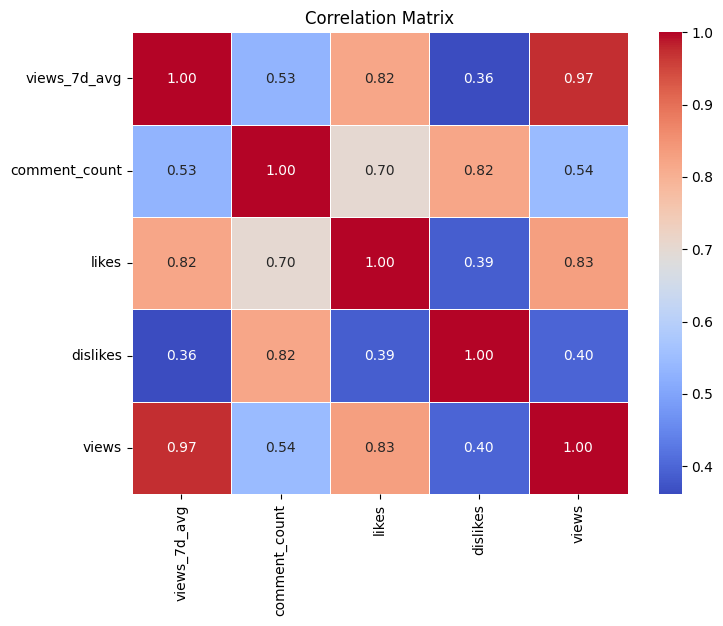

Correlation between views_7d_avg and views: 0.974
Correlation between comment_count and views: 0.544
Correlation between likes and views: 0.833
Correlation between dislikes and views: 0.398


In [8]:
# CORRELATION CALCULATION
# Numeric columns for correlation calculation
numeric_features = ['views_7d_avg','comment_count', 'likes', 'dislikes', 'views']

# Calculate correlation matrix for selected numeric features
correlation_scores = df[numeric_features].corr()

# CORRELATION VISUALIZATION
# Display the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_scores, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Print the individual correlations with views
for feature in numeric_features:
    if feature != 'views':  # Don't calculate correlation for the target itself
        correlation_score = df[feature].corr(df['views'])
        print(f"Correlation between {feature} and views: {correlation_score:.3f}")

##### 7-day moving average of views (views_7d_avg): This variable shows a very strong positive relationship with views, indicating that past performance is a key predictor for future views. Videos that have been performing well recently are likely to continue attracting more views.
##### Comments (comment_count): There is a moderate positive correlation with views, suggesting that as videos gain more views, they also tend to receive more comments. However, other factors could also influence the number of comments, indicating that comments are somewhat tied to views, but not as strongly as other engagement metrics like likes.
##### Likes: A strong positive relationship with views indicates that higher engagement (through likes) is strongly linked to a video’s success. Videos with more likes tend to have more views, signaling that popular videos are generally more liked by viewers.
##### Dislikes: While there is a weaker positive correlation with views, dislikes have a lesser impact on predicting views compared to likes and comments. Dislikes may indicate polarizing content, but they don't appear to be a major factor in driving the view count.
##### Publish hour (publish_hour): The correlation with views is very weak, suggesting that the time of day when a video is published has little to no impact on its total views. Other factors, such as content quality or engagement, are likely more important than the timing of publication.

In [10]:
# UNTUNED XGBOOST

# Create and fit an XGBoost model
xg_model = xgb.XGBRegressor()
xg_model.fit(X_train_scaled, y_train)

# Make predictions with the XGBoost model
xg_pred = xg_model.predict(X_test_scaled)

# Evaluate the XGBoost model
xg_mse = mean_squared_error(y_test, xg_pred)  # Mean Squared Error (MSE)
xg_r2 = r2_score(y_test, xg_pred)  # R-squared score
xg_mae = mean_absolute_error(y_test, xg_pred) # Mean Absolute Error (MAE)
xg_rmse = np.sqrt(mean_squared_error(y_test, xg_pred)) # Root MSE

# MODEL WITH FEATURE IMPORTANCE
# Fit the model
model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_train, y_train)

# PERFORMANCE
# XGBoost
print(f"Untuned XGBoost MSE: {xg_mse}")
print(f"Untuned XGBoost R²: {xg_r2}")
print(f"Untuned XGBoost MAE: {xg_mae}")
print(f"Untuned XGBoost RMSE: {xg_rmse}")

Untuned XGBoost MSE: 2058264189288.0747
Untuned XGBoost R²: 0.9490523330261411
Untuned XGBoost MAE: 222125.06417270072
Untuned XGBoost RMSE: 1434665.183688541


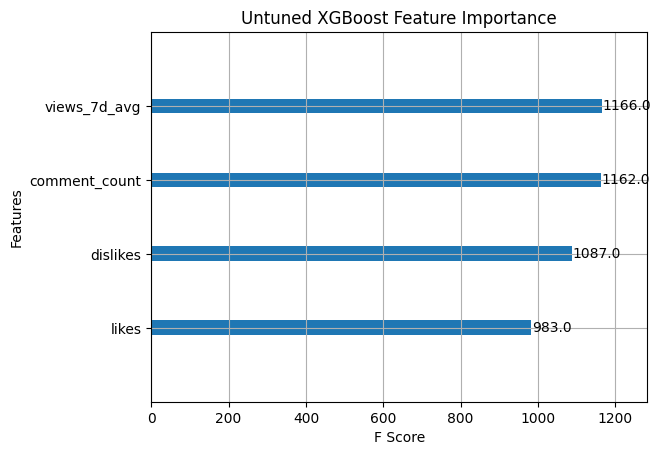

In [11]:
# UNTUNED XGBOOST FEATURE IMPORTANCE PLOT

# Plot feature importance
plot_importance(model_xgb, importance_type='weight')
plt.yticks(ticks=range(len(X_train.columns)), labels=X_train.columns)
plt.title('Untuned XGBoost Feature Importance')
plt.xlabel('F Score')
plt.ylabel('Features')
plt.show()  # Display the plot

##### Views 7-Day Average is the most influential feature in predicting view count. Its high importance in XGBoost demonstrates that recent viewing trends are a critical factor in estimating a video's future popularity.
##### Comments follow as the next most impactful feature. While not as dominant as the 7-day view average, they still indicate active viewer interaction and engagement, contributing significantly to predicting success.
##### Dislikes also holds importance, comparable to comments. This suggests that negative reactions, though traditionally seen as unfavorable, can still reflect heightened viewer interest and engagement.
##### Likes contribute to the prediction by highlighting viewer approval. Videos with more likes often generate additional interest. This indicates that both positive and negative audience reactions play a role in engagement, though likes have a smaller overall effect compared to other key features.

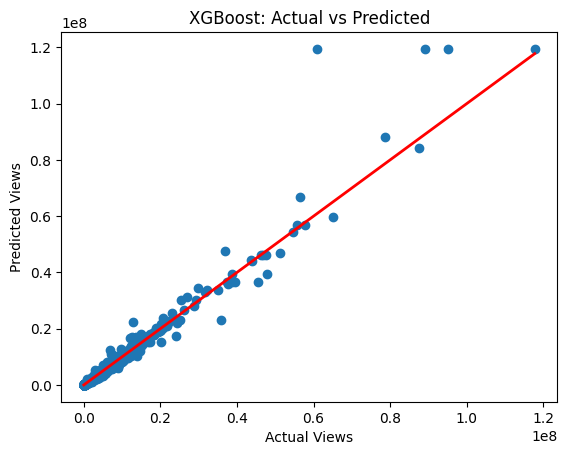

In [13]:
# UNTUNED PREDICTED VS. ACTUAL FOR XGBOOST

# Predicted vs Actual for XGBoost
plt.scatter(y_test, xg_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.title('XGBoost: Actual vs Predicted')
plt.xlabel('Actual Views')
plt.ylabel('Predicted Views')
plt.show()

In [14]:
# XGBOOST - HYPERPARAMATER TUNING 

# Set up the parameter grid for XGBoost
param_grid_xgb = {
     'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6],
    'subsample': [0.8, 1.0]
}

# Perform GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(xgb.XGBRegressor(), param_grid_xgb, cv=5, scoring='neg_mean_squared_error')
grid_search_xgb.fit(X_train_scaled, y_train)

# PERFORMANCE
# Get the best parameters
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)

# Evaluate the best XGBoost model
best_xgb_model = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test_scaled)

# Recalculate MSE and R² for the tuned model
xg_mse_tuned = mean_squared_error(y_test, y_pred_xgb)
xg_r2_tuned = r2_score(y_test, y_pred_xgb)
xg_mae_tuned = mean_absolute_error(y_test, y_pred_xgb)
xg_rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print("Tuned XGBoost MSE:", xg_mse_tuned)
print("Tuned XGBoost R²:", xg_r2_tuned)
print("Tuned XGBoost MAE:", xg_mae_tuned)
print("Tuned XGBoost RMSE:", xg_rmse_tuned)

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}
Tuned XGBoost MSE: 2365998966851.6396
Tuned XGBoost R²: 0.9414350557858437
Tuned XGBoost MAE: 252720.34125190548
Tuned XGBoost RMSE: 1538180.407771351


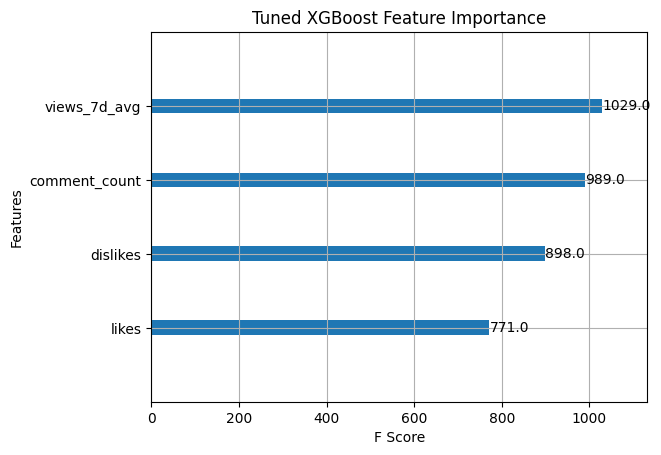

In [21]:
# TUNED XGBOOST FEATURE IMPORTANCE PLOT

# Plot feature importance for the tuned XGBoost model
plot_importance(best_xgb_model, importance_type='weight')
plt.yticks(ticks=range(len(X_train.columns)), labels=X_train.columns)
plt.title('Tuned XGBoost Feature Importance')
plt.xlabel('F Score')
plt.ylabel('Features')
plt.show()  # Display the plot

##### Views 7-Day Average continues to be the most influential feature in predicting view count. After tuning, its importance slightly decreases, but it remains the strongest predictor of a video's future popularity. The difference between Views 7-Day Average and Comments increases after tuning, suggesting that the model places even more emphasis on Views 7-Day Average relative to Comments.
##### Comments show a decrease in importance after tuning. Although still a significant factor, their contribution to predicting views is slightly diminished in the tuned model compared to the untuned one. This shift indicates that while comments are still useful, the model now places relatively more importance on other features like Views 7-Day Average.
##### Dislikes see a notable decrease in importance after tuning. The gap between Comments and Dislikes narrows in the tuned model, suggesting that Dislikes become relatively less important, while Likes also take on a diminished role in comparison.
##### Likes experience a noticeable reduction in importance after tuning as well. This indicates that while Likes continue to contribute to predicting view count, their role becomes less significant after the model is fine-tuned. The model now shifts its focus toward other features like Dislikes and Comments, highlighting their growing influence.

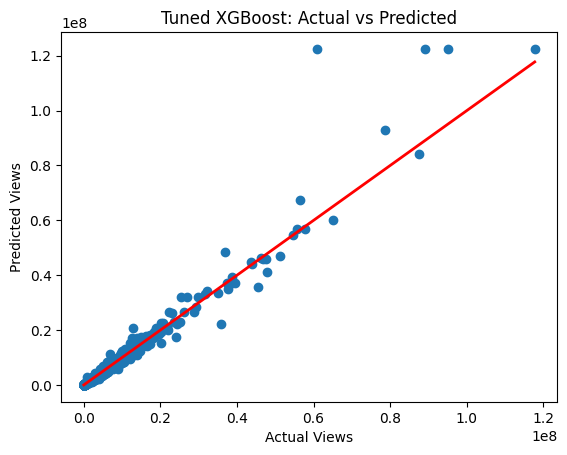

In [26]:
# TUNED PREDICTED VS. ACTUAL FOR XGBOOST

# Recalculate predictions for tuned model
xg_pred_tuned = best_xgb_model.predict(X_test_scaled)

# Reprint Predicted vs Actual for tuned XGBoost
plt.scatter(y_test, xg_pred_tuned)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.title('Tuned XGBoost: Actual vs Predicted')
plt.xlabel('Actual Views')
plt.ylabel('Predicted Views')
plt.show()

In [27]:
tuned_xgb = {
    'MSE': xg_mse_tuned,
    'R²': xg_r2_tuned,
    'MAE': xg_mae_tuned,
    'RMSE': xg_rmse_tuned
}
pd.DataFrame([tuned_xgb]).to_csv('xgb_results.csv', index=False)

In [28]:
untuned_xgb = {
    'MSE': xg_mse,
    'R²': xg_r2,
    'MAE': xg_mae,
    'RMSE': xg_rmse
}
pd.DataFrame([untuned_xgb]).to_csv('untunedxgb_results.csv', index=False)